<a href="https://colab.research.google.com/github/AlexH20/Supervised-ML-sentiment-measures/blob/main/Results_and_Descriptive_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descriptive statistics

In [1]:
%%capture
!pip install tabulate
!pip install pysentiment2
!pip install linearmodels
!pip install stargazer

import pandas as pd
pd.options.mode.chained_assignment = None 
import pysentiment2 as ps
from google.colab import drive 
from tabulate import tabulate
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as md
import statsmodels.api as sm
from linearmodels.panel import PooledOLS
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from sklearn.metrics import mean_squared_error
from google.colab import files

pd.set_option('display.expand_frame_repr', False)
drive.mount("/content/gdrive")

def count_words(Text):
    word_count = len(re.findall(r'\w+', Text))
    return word_count

#Function to split initial dataframe into dataframes grouped by year
def split_years(dt):
    dt["Year"] = dt["Date"].dt.year
    return [dt[dt["Year"] == y] for y in dt["Year"].unique()]

In [12]:
#Data raw
data = pd.read_csv("gdrive/My Drive/Thesis/processed data/processdata_woSWandPS.csv")
data["Date"] = pd.to_datetime(data["Date"], format = "%Y-%m-%d")
data["Word Count"] = [count_words(x) for x in data.Text]

#Data without sentiment measures
data_final = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/data_whole_woScAR.csv")
data_final_ot = data_final[data_final["word_count"]!= 0]
data_final_ot["Date"] = pd.to_datetime(data_final_ot["Date"], format = "%Y-%m-%d")

#Data DM methods
data_dm = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/data_whole_woScAR_dm.csv")
data_dm["Date"] = pd.to_datetime(data_dm["Date"], format = "%Y-%m-%d")
data_dm["Date"] = pd.to_datetime(data_dm["Date"])
data_dm["Year"] = [x.year for x in data_dm["Date"]]
data_dm["Month"] = [x.month for x in data_dm["Date"]]
data_dm["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data_dm.iterrows()]
data_dm = data_dm[~data_dm["ordered_month"].isin([0,1,2,3,56,57,58,59,60])]
data_dm = data_dm.fillna(0)

#Data RF with one- and two-grams
data_rf_12 = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/data_whole_woScAR_RF12.csv", index_col = False)
data_rf_12["Date"] = pd.to_datetime(data_rf_12["Date"])
data_rf_12["Year"] = [x.year for x in data_rf_12["Date"]]
data_rf_12["Month"] = [x.month for x in data_rf_12["Date"]]
data_rf_12["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data_rf_12.iterrows()]
data_rf_12 = data_rf_12[~data_rf_12["ordered_month"].isin([0,1,2,3,56,57,58,59,60])]
data_rf_12 = data_rf_12.fillna(0)

#Data RF with FinBERT as encoder
data_rf_Fin = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/data_whole_woScAR_RFFin.csv")
data_rf_Fin["Date"] = pd.to_datetime(data_rf_Fin["Date"])
data_rf_Fin["Year"] = [x.year for x in data_rf_Fin["Date"]]
data_rf_Fin["Month"] = [x.month for x in data_rf_Fin["Date"]]
data_rf_Fin["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data_rf_Fin.iterrows()]
data_rf_Fin = data_rf_Fin[~data_rf_Fin["ordered_month"].isin([0,1,2,3,56,57,58,59,60])]
data_rf_Fin = data_rf_Fin.fillna(0)

#Data FinBERT as encoder + NN
data_Fin = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/data_whole_woScAR_FinNN.csv")
data_Fin["Date"] = pd.to_datetime(data_Fin["Date"])
data_Fin["Year"] = [x.year for x in data_Fin["Date"]]
data_Fin["Month"] = [x.month for x in data_Fin["Date"]]
data_Fin["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data_Fin.iterrows()]
data_Fin = data_Fin[~data_Fin["ordered_month"].isin([0,1,2,3,56,57,58,59,60])]
data_Fin = data_Fin.fillna(0)

#Fama French Factors
data_ff = pd.read_csv("gdrive/My Drive/Thesis/processed data/CAR_regression/datasets_final/famafrenchfactors.csv")
data_ff["Date"] = pd.to_datetime(data_ff["date"], format = "%Y%m%d")
data_ff.drop("date", axis = 1, inplace = True)
#Merge every dataframe with sentiment measures

data_full = data_dm
#Add all sentiment measures to one dataframe
data_full["abret RF12"] = data_rf_12["AR_RF"]
data_full["abret RFFin"] = data_rf_Fin["AR_RFFin"]
data_full["abret FinNN"] = data_Fin["AR_FinNN"]
#Rename columns and set Size to ln(Size)
data_full["ln(Size)"] = np.log(data_full["Size"])
data_full.rename({"Return":"ret", "AR": "abret", "HIV4_tone":"HIV4 Tone", "LM_tone":"LM Tone"}, axis = 1,inplace = True)
#Merge FF3 Data
data_full = data_full.merge(data_ff, how= "left", left_on= ["Date"], right_on = ["Date"])
#Get excess return over risk-free rate
data_full["retrf"] = data_full["ret"] - data_full["rf"]
#Replace mktrf from FF database with value-weighted CRSP market return used with abnormal returns (otherwise small discrepancy)
data_full["mkt"] = data_full["ret"] - data_full["abret"]
data_full.drop("mktrf", axis = 1, inplace = True)
data_full["mktrf"] = data_full["mkt"] - data_full["rf"]
#Abnormal returns were added later, remove duplicate of STZ
data_full.drop_duplicates(subset = ["Date", "Ticker"], keep = "first", inplace = True)

**Descriptive Statistics of raw dataset:**

In [14]:
data_splt_years = split_years(data)
data_fill = []

for df_year_splt in data_splt_years:
    year = df_year_splt["Date"].iloc[0].year
    obs_count = len(df_year_splt)
    mean_word_count = round(df_year_splt["Word Count"].mean(),0)
    company_count = df_year_splt["Ticker"].nunique()

    data_fill.append([year, obs_count, mean_word_count, company_count])

#Calculate the metrics for the whole dataset
obs_count = len(data)
mean_word_count = round(data["Word Count"].mean(),0)
company_count = data["Ticker"].nunique()

data_fill.append(["All years", obs_count, mean_word_count, company_count])

df_by_year = pd.DataFrame(data_fill ,columns = ["Year", "News Articles", "Mean Word Count", "Company Count"])

print(tabulate(df_by_year, headers = "keys", tablefmt = "psql"))

+----+-----------+-----------------+-------------------+-----------------+
|    | Year      |   News Articles |   Mean Word Count |   Company Count |
|----+-----------+-----------------+-------------------+-----------------|
|  0 | 2009      |             111 |               849 |              70 |
|  1 | 2010      |            2792 |               434 |             865 |
|  2 | 2011      |            4277 |               460 |            1001 |
|  3 | 2012      |           10261 |               335 |            2279 |
|  4 | 2013      |           13143 |               275 |            3076 |
|  5 | 2014      |           26234 |               293 |            3997 |
|  6 | 2015      |           35458 |               344 |            4312 |
|  7 | 2016      |           36569 |               384 |            4261 |
|  8 | 2017      |           39630 |               479 |            4188 |
|  9 | 2018      |           77086 |               670 |            5195 |
| 10 | 2019      |       

**Extract Top 100 companies w.r.t news frequency in years 2015 till 2019:**

In [15]:
#Get top 120 companies with regards to news frequency (later only top 100, since some will be removed like SPX)

yearst = [2015, 2016, 2017, 2018, 2019]

data = data[data.Year.isin(yearst) == True]
unique_data_company =  data.groupby("Ticker").nunique()

unique_data_company.sort_values(by = "Text", ascending = False, inplace = True)

print(list(unique_data_company.index[0:120]))

['AAPL', 'AMZN', 'TSLA', 'FB', 'BA', 'NFLX', 'DIS', 'EFX', 'SPX', 'BAC', 'INTC', 'DAX', 'F', 'GLD', 'GE', 'GM', 'MSFT', 'SBUX', 'AIR', 'AAL', 'IBM', 'JPM', 'CMG', 'WFC', 'C', 'TWTR', 'WMT', 'MCD', 'AMD', 'NVDA', 'JNJ', 'GS', 'BABA', 'CAT', 'MU', 'CSCO', 'XOM', 'CVX', 'BP', 'GOOGL', 'USD', 'GPRO', 'COST', 'QQQ', 'HD', 'SQ', 'NKE', 'KO', 'TGT', 'AXP', 'ATVI', 'CMCSA', 'SNAP', 'DAL', 'LMT', 'T', 'ABBV', 'PFE', 'ADBE', 'GILD', 'CRM', 'VZ', 'AVGO', 'BX', 'LULU', 'BLK', 'FIT', 'KMI', 'BBY', 'UNH', 'AGI', 'AA', 'PG', 'AMAT', 'M', 'MRK', 'BIDU', 'QCOM', 'JCP', 'FDX', 'AMGN', 'BMY', 'ORCL', 'PYPL', 'BHP', 'MA', 'FRA', 'KR', 'SHOP', 'MO', 'PM', 'GME', 'CHK', 'VRX', 'ABX', 'MMM', 'COP', 'BBBY', 'UTX', 'IRBT', 'MS', 'SPY', 'FCX', 'HAL', 'AGN', 'UAL', 'HPQ', 'JWN', 'CVS', 'CELG', 'EA', 'STZ', 'V', 'APC', 'AZN', 'EBAY', 'ACN', 'ADP', 'GLW', 'PEP']


**Descriptive statistics of final dataset:**

In [16]:
#Descriptive statistics of final dataset 
data_splt_years = split_years(data_final_ot)
data_fill = []

for df_year_splt in data_splt_years:
    year = df_year_splt["Date"].iloc[0].year
    obs_count = len(df_year_splt)
    mean_word_count = round(df_year_splt["word_count"].mean(),0)
    company_count = df_year_splt["Ticker"].nunique()

    data_fill.append([year, obs_count, mean_word_count, company_count])

#Calculate the metrics for the whole dataset
obs_count = len(data_final_ot)
mean_word_count = round(data_final_ot["word_count"].mean(),0)
company_count = data_final_ot["Ticker"].nunique()

data_fill.append(["All years", obs_count, mean_word_count, company_count])

df_by_year = pd.DataFrame(data_fill ,columns = ["Year", "News Articles (post-merge)", "Mean Word Count", "Company Count"])

print(tabulate(df_by_year, headers = "keys", tablefmt = "psql"))

+----+-----------+------------------------------+-------------------+-----------------+
|    | Year      |   News Articles (post-merge) |   Mean Word Count |   Company Count |
|----+-----------+------------------------------+-------------------+-----------------|
|  0 | 2015      |                         4403 |               822 |             100 |
|  1 | 2016      |                         5415 |               839 |             100 |
|  2 | 2017      |                         5775 |               921 |             100 |
|  3 | 2018      |                         8516 |              1353 |             100 |
|  4 | 2019      |                         6476 |              1401 |             100 |
|  5 | All years |                        30585 |              1114 |             100 |
+----+-----------+------------------------------+-------------------+-----------------+


**Sample description variables:**

In [17]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
data_full_des = data_full[["ret", "mkt", "rf", "smb", "hml", "Nasdaq", "Turnover", "ln(Size)", "BTM", "HIV4 Tone", "LM Tone", "abret", "abret RF12", "abret RFFin", "abret FinNN"]]
des_table = data_full_des.describe().loc[["mean", "std", "25%", "50%", "75%"]]
print(des_table.T)

                mean     std      25%      50%      75%
ret          0.00050 0.01929 -0.00745  0.00065  0.00882
mkt          0.00039 0.00839 -0.00283  0.00051  0.00463
rf           0.00004 0.00003  0.00001  0.00003  0.00007
smb         -0.00010 0.00509 -0.00340 -0.00020  0.00310
hml         -0.00013 0.00552 -0.00360 -0.00040  0.00300
Nasdaq       0.46000 0.49840  0.00000  0.00000  1.00000
Turnover     1.86903 1.95710  0.75836  1.17449  2.04577
ln(Size)    17.86940 1.41506 17.13803 18.15292 18.91580
BTM          0.52766 1.57726  0.12261  0.25636  0.49571
HIV4 Tone    0.09926 0.20010  0.00000  0.00000  0.00000
LM Tone     -0.01359 0.23564  0.00000  0.00000  0.00000
abret        0.00010 0.01703 -0.00656  0.00005  0.00670
abret RF12   0.00009 0.00219  0.00000  0.00000  0.00000
abret RFFin  0.00008 0.00394  0.00000  0.00000  0.00000
abret FinNN -0.01475 0.07653  0.00000  0.00000  0.00000


**Correlation Matrix of sentiment measures:**

In [18]:
data_full_cor = data_full[["HIV4 Tone", "LM Tone", "abret RF12", "abret RFFin", "abret FinNN"]]
corr_matrix = data_full_cor.corr()
print(corr_matrix)

             HIV4 Tone  LM Tone  abret RF12  abret RFFin  abret FinNN
HIV4 Tone      1.00000  0.15900     0.06502      0.02615     -0.26837
LM Tone        0.15900  1.00000     0.01213      0.00233     -0.00110
abret RF12     0.06502  0.01213     1.00000      0.00404     -0.01625
abret RFFin    0.02615  0.00233     0.00404      1.00000      0.00432
abret FinNN   -0.26837 -0.00110    -0.01625      0.00432      1.00000


**Dictionary Methods Comparison: AAPL 2015 Q2**

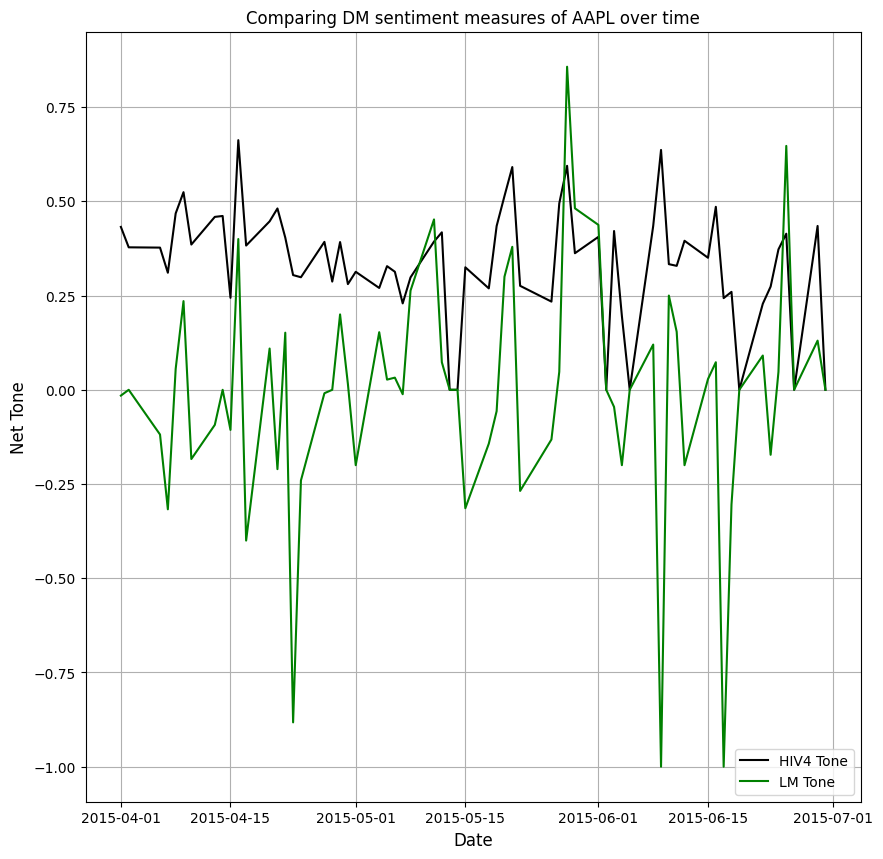

In [28]:
data_aapl = data_full.loc[data_full["Ticker"].isin(["AAPL"])]
data_aapl["Date"] = pd.to_datetime(data_aapl["Date"], format = "%Y-%m-%d")
data_aapl = data_aapl[data_aapl["ordered_month"].isin([4,5,6])]

sentiment_measures = ["HIV4 Tone", "LM Tone"]
colors = {"HIV4 Tone":"black", "LM Tone":"green"}

fig1, ax1 = plt.subplots(figsize = (10, 10))

for sentiment in sentiment_measures:
  ax1.plot(data_aapl["Date"], data_aapl[sentiment], c = colors[sentiment],label = sentiment)

plt.grid()
plt.title("Comparing DM sentiment measures of AAPL over time")
plt.xlabel("Date", size=12)
plt.ylabel("Net Tone", size=12)
plt.legend(loc = 4)
plt.show()

**Supervised Machine Learning Methods Comparison: AAPL 2015 Q2**

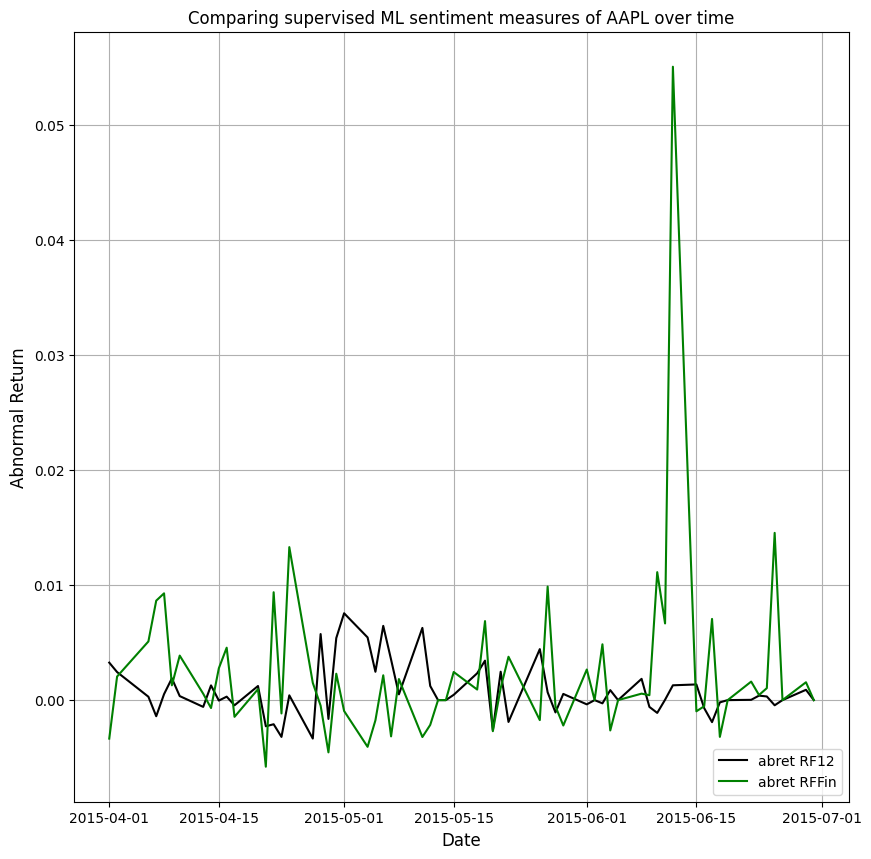

In [22]:
sentiment_measures = ["abret RF12", "abret RFFin"]
colors = {"abret RF12":"black", "abret RFFin":"green"}

fig1, ax1 = plt.subplots(figsize = (10, 10))

for sentiment in sentiment_measures:
  ax1.plot(data_aapl["Date"], data_aapl[sentiment], c = colors[sentiment],label = sentiment)

plt.grid()
plt.title("Comparing supervised ML sentiment measures of AAPL over time")
plt.xlabel("Date", size=12)
plt.ylabel("Abnormal Return", size=12)
plt.legend(loc = 4)
plt.show()

Supervised Machine Learning Measures and Abnormal Returns Comparison: AAPL 2015 Q2

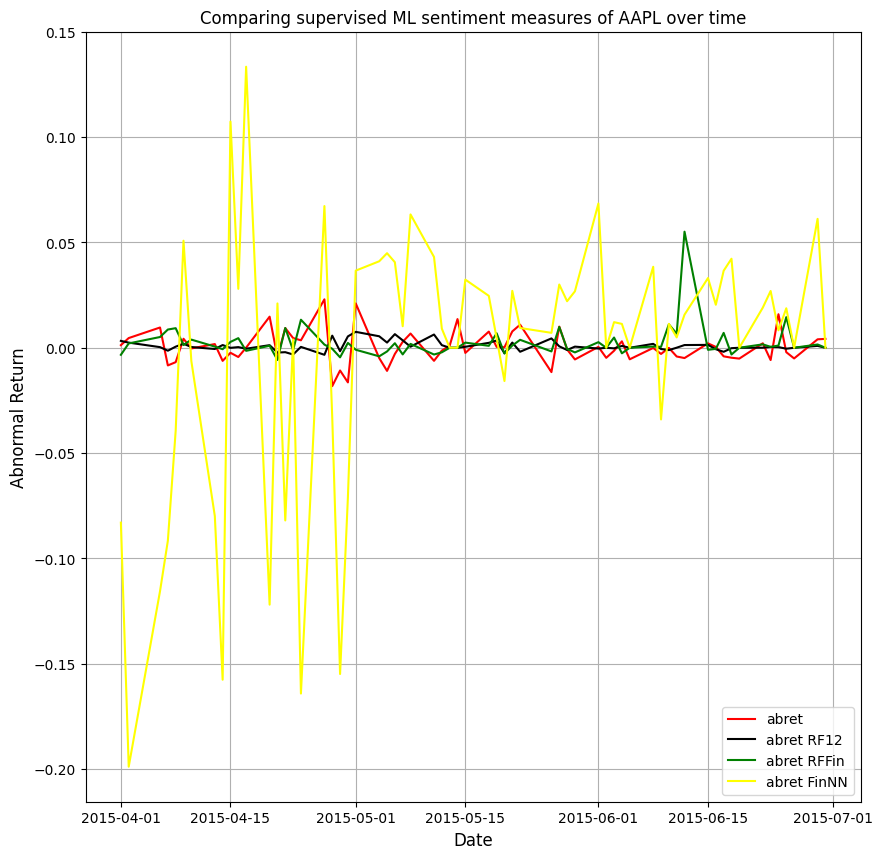

In [23]:
sentiment_measures = ["abret", "abret RF12", "abret RFFin", "abret FinNN"]
colors = {"abret": "red", "abret RF12":"black", "abret RFFin":"green", "abret FinNN": "yellow"}

fig1, ax1 = plt.subplots(figsize = (10, 10))

for sentiment in sentiment_measures:
  ax1.plot(data_aapl["Date"], data_aapl[sentiment], c = colors[sentiment],label = sentiment)

plt.grid()
plt.title("Comparing supervised ML sentiment measures of AAPL over time")
plt.xlabel("Date", size=12)
plt.ylabel("Abnormal Return", size=12)
plt.legend(loc = 4)
plt.show()

**Mean Squared Error of Return Sentiment Measures:**

In [24]:
mse_rf12 = mean_squared_error(data_full["abret"], data_full["abret RF12"])
mse_rffin = mean_squared_error(data_full["abret"], data_full["abret RFFin"])
mse_finnn = mean_squared_error(data_full["abret"], data_full["abret FinNN"])
print("The MSE of RF with one- anf two-grams is: {}".format(mse_rf12))
print("The MSE of RF with FinBERT as encoder is: {}".format(mse_rffin))
print("The MSE FinBERT + NN is: {}".format(mse_finnn))

The MSE of RF with one- anf two-grams is: 0.0002939298987136642
The MSE of RF with FinBERT as encoder is: 0.00030441933532325376
The MSE FinBERT + NN is: 0.0063712693974970975


**Results of panel data regression:**

In [25]:
#HIV dictionary 

endg_var = "abret"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "HIV4 Tone"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_hiv4 = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_hiv4 = pooled_olsr_model_hiv4.fit()
print(pooled_olsr_model_results_hiv4.summary())


#LM dictionary

endg_var = "abret"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "LM Tone"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_lm = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_lm = pooled_olsr_model_lm.fit()
print(pooled_olsr_model_results_lm.summary())

#RF12

endg_var = "abret"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "abret RF12"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_rf12 = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_rf12 = pooled_olsr_model_rf12.fit()
print(pooled_olsr_model_results_rf12.summary())

#RF with FinBERT as encoder

endg_var = "abret"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "abret RFFin"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_rffin = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_rffin = pooled_olsr_model_rffin.fit()
print(pooled_olsr_model_results_rffin.summary())

#FinBERT + NN

endg_var = "abret"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "abret FinNN"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_finnn = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_finnn = pooled_olsr_model_finnn.fit()
print(pooled_olsr_model_results_finnn.summary())





                            OLS Regression Results                            
Dep. Variable:                  abret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.254
Date:                Fri, 17 Jun 2022   Prob (F-statistic):           1.39e-06
Time:                        11:53:46   Log-Likelihood:             2.8955e+05
No. Observations:              109100   AIC:                        -5.791e+05
Df Residuals:                  109093   BIC:                        -5.790e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.486e-05      0.000     -0.632      0.5

**Results of FF3 regression:**

In [26]:
data_full["retrf"] = data_full["ret"] - data_full["rf"]

#HIV dictionary 


endg_var = "retrf"
exog_var = ["mktrf", "smb", "hml", "Nasdaq", "BTM", "Size", "Turnover", "HIV4 Tone"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_hiv4 = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_hiv4 = pooled_olsr_model_hiv4.fit()
print(pooled_olsr_model_results_hiv4.summary())


#LM dictionary

endg_var = "retrf"
exog_var = ["mktrf", "smb", "hml", "Nasdaq", "BTM", "Size", "Turnover", "LM Tone"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_lm = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_lm = pooled_olsr_model_lm.fit()
print(pooled_olsr_model_results_lm.summary())

#RF12

endg_var = "retrf"
exog_var = ["mktrf", "smb", "hml", "Nasdaq", "BTM", "Size", "Turnover", "abret RF12"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_rf12 = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_rf12 = pooled_olsr_model_rf12.fit()
print(pooled_olsr_model_results_rf12.summary())

#RF with FinBERT as encoder

endg_var = "retrf"
exog_var = ["mktrf", "smb", "hml", "Nasdaq", "BTM", "Size", "Turnover", "abret RFFin"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_rffin = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_rffin = pooled_olsr_model_rffin.fit()
print(pooled_olsr_model_results_rffin.summary())

#FinBERT + NN

endg_var = "retrf"
exog_var = ["mktrf", "smb", "hml", "Nasdaq", "BTM", "Size", "Turnover", "abret FinNN"]

pooled_y = data_full[endg_var]
pooled_x = data_full[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_finnn = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_finnn = pooled_olsr_model_finnn.fit()
print(pooled_olsr_model_results_finnn.summary())

                            OLS Regression Results                            
Dep. Variable:                  retrf   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     3889.
Date:                Fri, 17 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:54:30   Log-Likelihood:             2.8964e+05
No. Observations:              109100   AIC:                        -5.793e+05
Df Residuals:                  109091   BIC:                        -5.792e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.858e-05      0.000     -0.863      0.3

**R-squared of FF3 models:**

In [27]:
print("R-squared of HIV4: {}".format(pooled_olsr_model_results_hiv4.rsquared))
print("R-squared of LM: {}".format(pooled_olsr_model_results_lm.rsquared))
print("R-squared of RF12: {}".format(pooled_olsr_model_results_rf12.rsquared))
print("R-squared of RFFin: {}".format(pooled_olsr_model_results_rffin.rsquared))
print("R-squared of FinNN: {}".format(pooled_olsr_model_results_finnn.rsquared))

R-squared of HIV4: 0.2219026080553872
R-squared of LM: 0.22217471393757404
R-squared of RF12: 0.22187509692569363
R-squared of RFFin: 0.2218304850673346
R-squared of FinNN: 0.2217703578167517
